In [10]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve


In [11]:
# read in the data
full_data = pd.read_csv('../Data/expanded_clean.csv', index_col=0)

# rename the 'class' column to 'poisonous' for clarity
# and convert to a binary variable
full_data.rename(columns={'class':'poisonous'}, inplace=True)
full_data['poisonous'] = full_data['poisonous'] == 'POISONOUS'

# Replace all '-' characters in the headers with '_'
full_data.columns = full_data.columns.str.replace('-', '_')

# Remove a ? from the headers
full_data.columns = full_data.columns.str.replace('?', '')

full_data.head()

/var/folders/j1/6w3brg1548b8nh3hd3xp_x840000gn/T/ipykernel_16071/1524892990.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data.columns = full_data.columns.str.replace('?', '')


,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [12]:
#Function to compute confusion matrix and prediction accuracy
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [29]:
# Split the data into training and test sets
train, test = train_test_split(full_data, test_size=0.15, random_state=100)

# Model based on Odor
We noticed during the EDA that the odor of the mushroom is highly correlated with the toxicity of the mushroom, with an almost perfect correlation. We will use this as our first model.

In [30]:
# Create a model to predict poisonous using odor

train_1 = train.copy()

# If odor is equal to ALMOND, ANISE, or NONE, set it to 0, else 1
train_1['odor'] = train_1['odor'].apply(lambda x: 0 if x in ['ALMOND', 'ANISE', 'NONE'] else 1).astype(int)

train_1['poisonous'] = train_1['poisonous'].astype(int)

# Train a linear regression model
model_1 = smf.logit(formula='poisonous~odor', data=train_1).fit()
model_1.summary()

         Current function value: 0.065608
         Iterations: 35


/Users/josephprette/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              poisonous   No. Observations:                 7153
Model:                          Logit   Df Residuals:                     7151
Method:                           MLE   Df Model:                            1
Date:                Sun, 12 Mar 2023   Pseudo R-squ.:                  0.9050
Time:                        17:01:20   Log-Likelihood:                -469.30
converged:                      False   LL-Null:                       -4941.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6334      0.101    -36.042      0.000      -3.831      -3.436
odor          29.9791   9253.047      0.003      0.997   -1.81e+04    1.82e+04
==============================================================================

Possibly complete quasi-separation: A fraction 0.45 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Classification accuracy = 98.5%
Precision = 100.0%
TPR or Recall = 96.8%
FNR = 3.2%
FPR = 0.0%
ROC-AUC = 98.4%


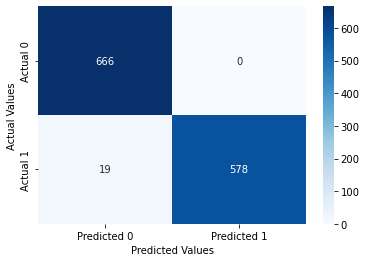

In [31]:
# Print the confusion matrix for test_1
test_1 = test.copy()
test_1['odor'] = test_1['odor'].apply(lambda x: 0 if x in ['ALMOND', 'ANISE', 'NONE'] else 1).astype(int)
test_1['poisonous'] = test_1['poisonous'].astype(int)

confusion_matrix_data(test_1[['odor']], test_1['poisonous'], model_1)

According to the confusion matrix run on the test data, the model is able to correctly predict 98.5% of the mushrooms, with 100% precision and 96.8% recall.

This is a very good model for our purposes.

# Model based on visual features
We will now try to create a model without the odor feature, and instead use the visual features of the mushroom. 

In [32]:
train

,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
5321,True,FLAT,SCALY,YELLOW,NO,FOUL,FREE,CLOSE,BROAD,PINK,...,SILKY,BROWN,BUFF,PARTIAL,WHITE,ONE,LARGE,CHOCOLATE,SOLITARY,PATHS
6411,True,CONVEX,SCALY,RED,NO,FOUL,FREE,CLOSE,NARROW,BUFF,...,SILKY,PINK,WHITE,PARTIAL,WHITE,ONE,EVANESCENT,WHITE,SEVERAL,PATHS
1812,False,FLAT,SMOOTH,GRAY,NO,NONE,FREE,CROWDED,BROAD,CHOCOLATE,...,FIBROUS,WHITE,WHITE,PARTIAL,WHITE,ONE,EVANESCENT,BLACK,SCATTERED,GRASSES
7873,True,KNOBBED,SCALY,RED,NO,MUSTY,FREE,CLOSE,BROAD,YELLOW,...,SCALY,CINNAMON,CINNAMON,PARTIAL,WHITE,NONE,NONE,WHITE,CLUSTERED,WOODS
2197,False,CONVEX,FIBROUS,GRAY,BRUISES,NONE,FREE,CLOSE,BROAD,WHITE,...,SMOOTH,PINK,GRAY,PARTIAL,WHITE,ONE,PENDANT,BLACK,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,False,BELL,SCALY,YELLOW,BRUISES,ANISE,FREE,CLOSE,BROAD,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,NUMEROUS,MEADOWS
79,False,FLAT,FIBROUS,WHITE,BRUISES,ANISE,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
8039,False,CONVEX,FIBROUS,WHITE,NO,NONE,FREE,CROWDED,BROAD,WHITE,...,SILKY,WHITE,WHITE,PARTIAL,WHITE,TWO,PENDANT,WHITE,NUMEROUS,GRASSES
6936,True,FLAT,SMOOTH,BROWN,NO,SPICY,FREE,CLOSE,NARROW,BUFF,...,SILKY,WHITE,PINK,PARTIAL,WHITE,ONE,EVANESCENT,WHITE,SEVERAL,PATHS


In [33]:
train_2 = train.copy()

train_2['poisonous'] = train_2['poisonous'].astype(int)

columns_to_use = ['cap_shape', 'cap_surface', 'cap_color', 'bruises',
                  'gill_attachment', 'gill_spacing', 'gill_size', 'stalk_color_above_ring']

formula = 'poisonous ~ ' + ' + '.join(columns_to_use)

print(formula)

# Train a linear regression model
model_2 = smf.logit(formula=formula, data=train_2).fit()
model_2.summary()

poisonous ~ cap_shape + cap_surface + cap_color + bruises + gill_attachment + gill_spacing + gill_size + stalk_color_above_ring
         Current function value: 0.134357
         Iterations: 35


/Users/josephprette/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              poisonous   No. Observations:                 7153
Model:                          Logit   Df Residuals:                     7123
Method:                           MLE   Df Model:                           29
Date:                Sun, 12 Mar 2023   Pseudo R-squ.:                  0.8055
Time:                        17:01:27   Log-Likelihood:                -961.06
converged:                      False   LL-Null:                       -4941.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -2.9838   5.23e+06  -5.71e-07      1.000   -1.02e+07    1.02e+07
cap_shape[T.CONICAL]                  28.5980    1.7e+05      0.000      1.000   -3.32e+05    3.32e+05
cap_shape[T.CONVEX]                    1.2061      0.242      4.976      0.000       0.731       1.681
cap_shape[T.FLAT]                      1.5940      0.251      6.350      0.000       1.102       2.086
cap_shape[T.KNOBBED]                   0.3657      0.409      0.895      0.371      -0.436       1.167
cap_shape[T.SUNKEN]                  -20.3935    950.638     -0.021      0.983   -1883.610    1842.822
cap_surface[T.GROOVES]                25.9307   1.74e+04      0.001      0.999    -3.4e+04    3.41e+04
cap_surface[T.SCALY]                   1.2492      0.201      6.221      0.000       0.856       1.643
cap_surface[T.SMOOTH]                  3.6315      0.247     14.709      0.000       3.148       4.115
cap_color[T.BUFF]                      5.9038      0.404     14.599      0.000       5.111       6.696
cap_color[T.CINNAMON]                -11.2793    322.188     -0.035      0.972    -642.757     620.198
cap_color[T.GRAY]                      3.0607      0.300     10.206      0.000       2.473       3.649
cap_color[T.GREEN]                   -24.2186   7175.505     -0.003      0.997   -1.41e+04     1.4e+04
cap_color[T.PINK]                      4.9986      0.394     12.698      0.000       4.227       5.770
cap_color[T.PURPLE]                  -48.3165   1.32e+09  -3.67e-08      1.000   -2.58e+09    2.58e+09
cap_color[T.RED]                       0.5070      0.374      1.354      0.176      -0.227       1.241
cap_color[T.WHITE]                     3.3804      0.299     11.288      0.000       2.793       3.967
cap_color[T.YELLOW]                    2.6737      0.302      8.854      0.000       2.082       3.266
bruises[T.NO]                          3.6642      0.192     19.041      0.000       3.287       4.041
gill_attachment[T.FREE]               -1.8739   5.23e+06  -3.58e-07      1.000   -1.02e+07    1.02e+07
gill_spacing[T.CROWDED]               -6.5551      0.260    -25.257      0.000      -7.064      -6.046
gill_size[T.NARROW]                    5.8011      0.262     22.157      0.000       5.288       6.314
stalk_color_above_ring[T.BUFF]        18.9084   3853.728      0.005      0.996   -7534.260    7572.077
stalk_color_above_ring[T.CINNAMON]    40.3027   1.83e+06    2.2e-05      1.000   -3.59e+06    3.59e+06
stalk_color_above_ring[T.GRAY]       -22.3081   4213.556     -0.005      0.996   -8280.726    8236.110
stalk_color_above_ring[T.ORANGE]     -30.0583   5.23e+06  -5.75e-06      1.000   -1.02e+07    1.02e+07
stalk_color_above_ring[T.PINK]        -1.5333      0.328     -4.679      0.000      -2.176      -0.891
stalk_color_above_ring[T.RED]        -61.0719    2.3e+11  -2.65e-10      1.000   -4.51e+11    4.51e+11
stalk_color_above_ring[T.WHITE]       -3.5346   

<ipython-input-222-6cbc57fb0873>:15: RuntimeWarning: invalid value encountered in scalar divide
  percentage = p.get_height() / (p.get_height() + p.get_y())
<ipython-input-222-6cbc57fb0873>:15: RuntimeWarning: invalid value encountered in scalar divide
  percentage = p.get_height() / (p.get_height() + p.get_y())
<ipython-input-222-6cbc57fb0873>:15: RuntimeWarning: invalid value encountered in scalar divide
  percentage = p.get_height() / (p.get_height() + p.get_y())
<ipython-input-222-6cbc57fb0873>:15: RuntimeWarning: invalid value encountered in scalar divide
  percentage = p.get_height() / (p.get_height() + p.get_y())


<Figure size 432x288 with 0 Axes>

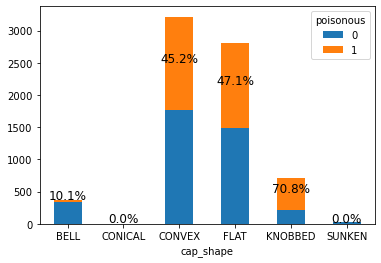

<Figure size 432x288 with 0 Axes>

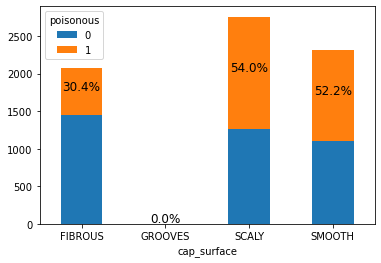

<Figure size 432x288 with 0 Axes>

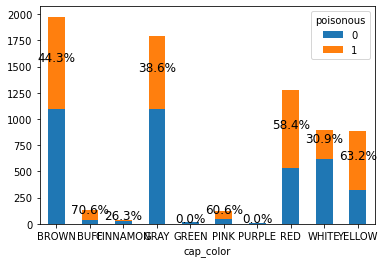

<Figure size 432x288 with 0 Axes>

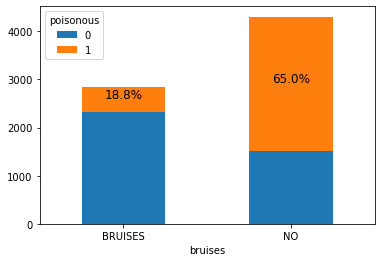

<Figure size 432x288 with 0 Axes>

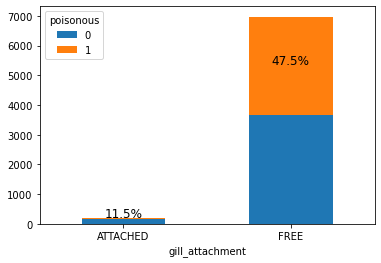

<Figure size 432x288 with 0 Axes>

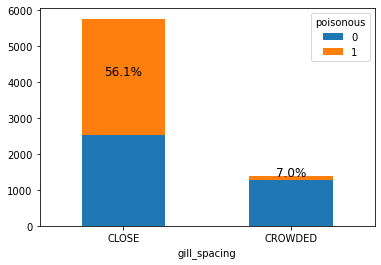

<Figure size 432x288 with 0 Axes>

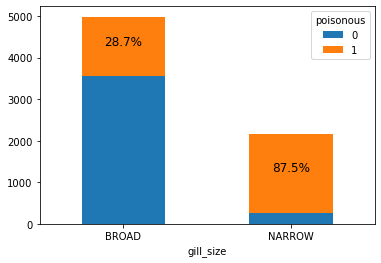

<Figure size 432x288 with 0 Axes>

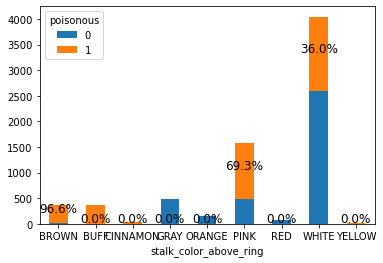

In [222]:
# For each column used in the model, plot a bar graph of the fields and the proportions that are poisonous
# Draw the percentage of poisonous mushrooms for each column in each bar
for column in columns_to_use:
    plt.figure()
     # Draw the percentage of poisonous mushrooms for each column in each bar as a number floating on top of the bar
    # main_df.groupby(col)['class'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axs.flat[main_df.columns.get_loc(col)])

    ax = train_2.groupby(column)['poisonous'].value_counts().unstack().plot(kind='bar', stacked=True)

    # Rotate the x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Above each stacked bar, draw the percentage of poisonous mushrooms
    for p in ax.patches:
        percentage = p.get_height() / (p.get_height() + p.get_y())

        # If percentage is nan, convert to 0 or 1 depending on the value of p.get_height()
        if np.isnan(percentage):
            if p.get_height() == 0:
                percentage = 0
            else:
                percentage = 1

        if percentage > 0.99:
            continue

        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() / 2
        ax.annotate('{:.1%}'.format(percentage), (x, y), ha='center', va='center', size=12, xytext=(0, 5), textcoords='offset points')
   
    

In [189]:
full_data.columns

Index(['poisonous', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',
       'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
       'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
       'stalk_surface_below_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number',
       'ring_type', 'spore_print_color', 'population', 'habitat'],
      dtype='object')

Classification accuracy = 96.7%
Precision = 95.4%
TPR or Recall = 97.7%
FNR = 2.3%
FPR = 4.2%
ROC-AUC = 98.8%


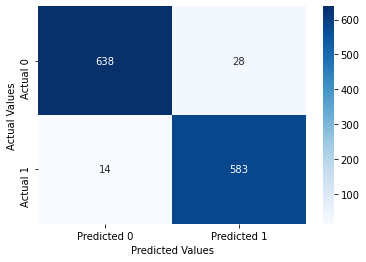

In [190]:
# Test the model on the test set
test_2 = test.copy()
test_2['poisonous'] = test_2['poisonous'].astype(int)

confusion_matrix_data(test_2[columns_to_use], test_2['poisonous'], model_2, cutoff=0.4)

In [191]:
def plot_precision_vs_threshold(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylabel("Precision/Recall")

When the threshold is 0.98047
the precision is 0.96576
the recall is 0.95677
maximizing_threshold is 0.98047


<AxesSubplot:xlabel='Threshold', ylabel='Precision/Recall'>

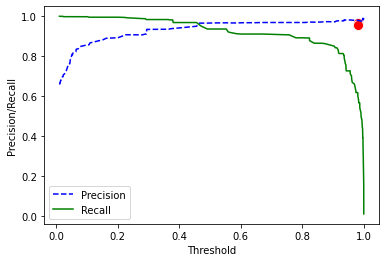

In [192]:
# Find the optimal cutoff
y = train_2['poisonous']
y_predict = model_2.predict(train_2)
p, r, prc_thresholds = precision_recall_curve(train_2['poisonous'], model_2.predict(train_2))

fpr, tpr, thresholds = roc_curve(y, y_predict)

plot_precision_vs_threshold(p, r, prc_thresholds)

maximizing_threshold = thresholds[np.argmax(p[:-1] * r[:-1])]

print(f"When the threshold is {round(maximizing_threshold, 5)}")
print(f"the precision is {round(p[np.argmin(np.abs(thresholds - maximizing_threshold))], 5)}")
print(f"the recall is {round(r[np.argmin(np.abs(thresholds - maximizing_threshold))], 5)}")
print(f"maximizing_threshold is {round(maximizing_threshold, 5)}")

# Find the point in precision where threshold is closest to maximizing_threshold

y0 = p[np.argmin(np.abs(thresholds - maximizing_threshold))]
y1 = r[np.argmin(np.abs(thresholds - maximizing_threshold))]

sns.scatterplot(x=[maximizing_threshold], y=[y0], color='red', s=100)
sns.scatterplot(x=[maximizing_threshold], y=[y1], color='red', s=100)

In [194]:
p.size

174

In [195]:
r.size

174

In [196]:
fpr.size

236